In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datasets import load_dataset
import nltk


In [4]:
test_dataset = pd.read_csv('sentiment-topic-test.tsv', sep='\t')


gold_label
positive    6
neutral     6
negative    6
Name: count, dtype: int64
count    18.000000
mean     14.666667
std       2.520504
min      10.000000
25%      13.250000
50%      14.000000
75%      16.000000
max      21.000000
Name: sentence_length, dtype: float64


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sofiavida/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


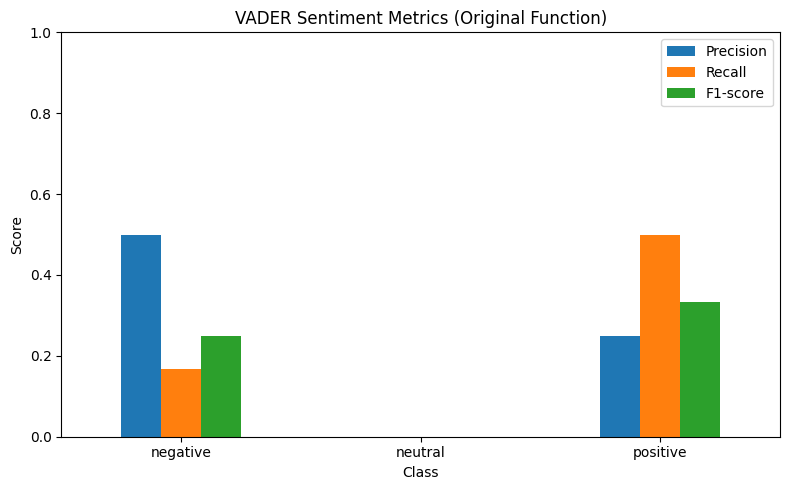

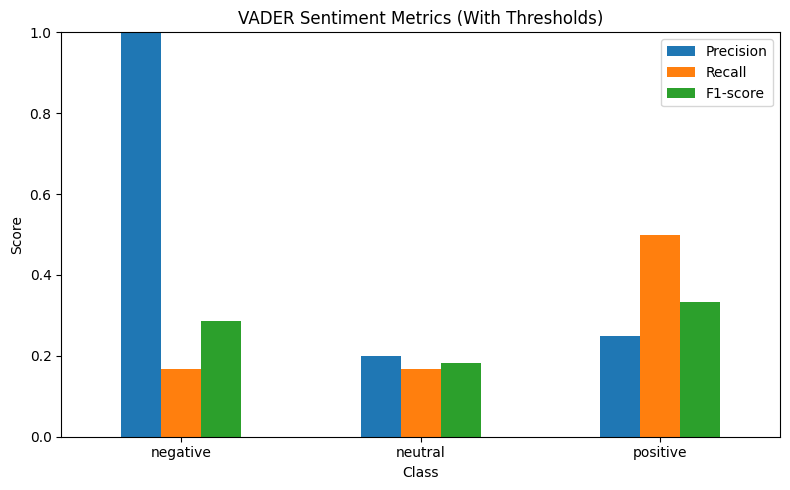

Version 1 metrics:
       Class  Precision    Recall  F1-score
0  negative       0.50  0.166667  0.250000
1   neutral       0.00  0.000000  0.000000
2  positive       0.25  0.500000  0.333333
Version 2 metrics:
       Class  Precision    Recall  F1-score
0  negative       1.00  0.166667  0.285714
1   neutral       0.20  0.166667  0.181818
2  positive       0.25  0.500000  0.333333


In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, precision_recall_fscore_support
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')

# Load test set
test_dataset = pd.read_csv('sentiment-topic-test.tsv', sep='\t')
test_dataset['gold_label'] = test_dataset['sentiment']

analyzer = SentimentIntensityAnalyzer()
print(test_dataset['gold_label'].value_counts())
test_dataset['sentence_length'] = test_dataset['sentence'].apply(lambda x: len(str(x).split()))
print(test_dataset['sentence_length'].describe())

# Version 1: Original (compound == 0 for neutral)
def vader_output_to_label_v1(vader_output):
    compound = vader_output['compound']
    if compound > 0:
        return 'positive'
    elif compound < 0:
        return 'negative'
    else:
        return 'neutral'

vader_preds_v1 = []
for sentence in test_dataset['sentence']:
    if isinstance(sentence, str):
        scores = analyzer.polarity_scores(sentence)
        vader_preds_v1.append(vader_output_to_label_v1(scores))
    else:
        vader_preds_v1.append(np.nan)
test_dataset['vader_label_v1'] = pd.Series(vader_preds_v1)

# Version 2: VADER thresholds
def vader_output_to_label_v2(vader_output):
    compound = vader_output['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

vader_preds_v2 = []
for sentence in test_dataset['sentence']:
    if isinstance(sentence, str):
        scores = analyzer.polarity_scores(sentence)
        vader_preds_v2.append(vader_output_to_label_v2(scores))
    else:
        vader_preds_v2.append(np.nan)
test_dataset['vader_label_v2'] = pd.Series(vader_preds_v2)


test_dataset = test_dataset.dropna(subset=['vader_label_v1', 'vader_label_v2'])

labels = ['negative', 'neutral', 'positive']

# Get metrics for each version
metrics1 = precision_recall_fscore_support(test_dataset['gold_label'], test_dataset['vader_label_v1'], labels=labels, zero_division=0)
metrics2 = precision_recall_fscore_support(test_dataset['gold_label'], test_dataset['vader_label_v2'], labels=labels, zero_division=0)


metrics_df1 = pd.DataFrame({
    'Class': labels,
    'Precision': metrics1[0],
    'Recall': metrics1[1],
    'F1-score': metrics1[2]
})
metrics_df2 = pd.DataFrame({
    'Class': labels,
    'Precision': metrics2[0],
    'Recall': metrics2[1],
    'F1-score': metrics2[2]
})

# Plot for Version 1
metrics_df1.set_index('Class')[['Precision', 'Recall', 'F1-score']].plot(kind='bar', figsize=(8, 5))
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('VADER Sentiment Metrics (Original Function)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot for Version 2
metrics_df2.set_index('Class')[['Precision', 'Recall', 'F1-score']].plot(kind='bar', figsize=(8, 5))
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('VADER Sentiment Metrics (With Thresholds)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print ("Version 1 metrics:\n", metrics_df1)
print ("Version 2 metrics:\n", metrics_df2)


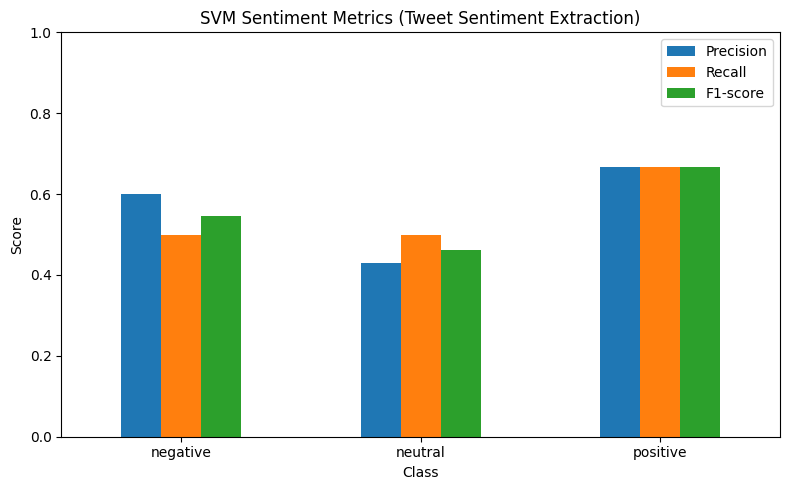

SVM metrics (trained on mteb/tweet_sentiment_extraction):
       Class  Precision    Recall  F1-score
0  negative   0.600000  0.500000  0.545455
1   neutral   0.428571  0.500000  0.461538
2  positive   0.666667  0.666667  0.666667


In [13]:
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline


dataset = load_dataset('mteb/tweet_sentiment_extraction')
train_data = dataset['train']
X_train = train_data['text']
y_train = train_data['label']


label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
y_train = [label_map[x] for x in y_train]


X_test = test_dataset['sentence'].tolist()
y_test = test_dataset['gold_label'].tolist()


svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', LinearSVC())
])
svm_pipeline.fit(X_train, y_train)
svm_preds = svm_pipeline.predict(X_test)
test_dataset['svm_label'] = svm_preds


metrics_svm = precision_recall_fscore_support(y_test, svm_preds, labels=labels, zero_division=0)
metrics_df_svm = pd.DataFrame({
    'Class': labels,
    'Precision': metrics_svm[0],
    'Recall': metrics_svm[1],
    'F1-score': metrics_svm[2]
})

metrics_df_svm.set_index('Class')[['Precision', 'Recall', 'F1-score']].plot(kind='bar', figsize=(8, 5))
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('SVM Sentiment Metrics (Tweet Sentiment Extraction)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("SVM metrics (trained on mteb/tweet_sentiment_extraction):\n", metrics_df_svm)
